# Mobile Scratch Detection with Detectron2

**Author:** Anirudhan Kasthuri 

**Overview:**  
This notebook demonstrates how to set up Detectron2 for instance segmentation on a custom “mobile scratch” dataset.  
We will cover:

1. Environment & logger setup  
2. Model configuration & inference  
3. Dataset registration & visualization  
4. Training on custom data  
5. Saving configuration  
6. Inference & evaluation on validation set  
7. Utility function for quick image segmentation  

---

## 1. Environment & Logger Setup

Ensure that Detectron2’s logger is initialized so we can monitor progress and warnings.


In [2]:
# Setup detectron2 logger for informative output
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Common libraries for data handling and visualization
import numpy as np
import os
import json
import cv2
import random

# Detectron2 utilities for model zoo, predictor, and config
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Matplotlib for inline display
from matplotlib.pyplot import imshow, axis, show


---

## 2. Model Configuration & Initial Inference

Load a Mask R-CNN from Detectron2’s model zoo, run it on a sample image, and visualize raw predictions.


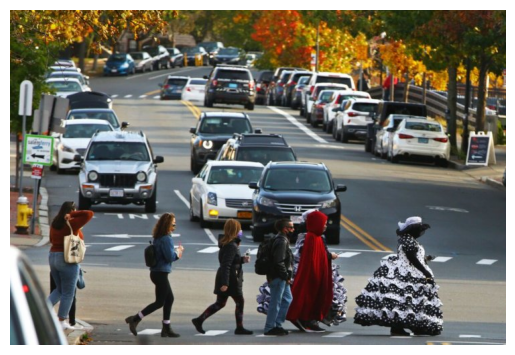

[05/18 18:00:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


c:\Users\aniru\anaconda3\envs\seg-synth\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


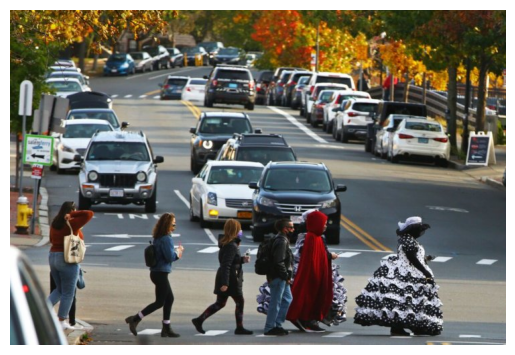

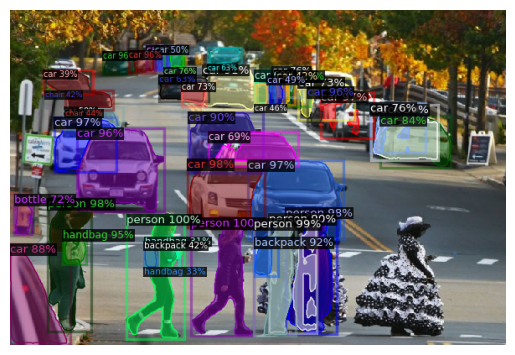

In [3]:
# Read and display the input image
my_new_image = cv2.cvtColor(cv2.imread('street_small.jpg'), cv2.COLOR_BGR2RGB)
imshow(my_new_image); axis('off'); show()

# Prepare config: threshold, weights, and predictor
cfg = get_cfg()
cfg.merge_from_file(
    "detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # Confidence threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
predictor = DefaultPredictor(cfg)

# Perform inference and visualize
outputs = predictor(my_new_image)
imshow(my_new_image); axis('off'); show()
v = Visualizer(
    my_new_image[:, :, ::-1],
    MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
    scale=0.8
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
imshow(out.get_image()[:, :, ::-1]); axis('off'); show()


---

## 3. Register Custom Dataset & Visualize Samples

Register COCO-format JSON annotations for training and validation, then display a couple of examples.


In [4]:
from detectron2.data.datasets import register_coco_instances

# Register custom datasets
register_coco_instances(
    "my_dataset_train",
    {},
    "Datasets/mobileScratches/training/training_ann.json",
    "Datasets/mobileScratches/training"
)
register_coco_instances(
    "my_dataset_val",
    {},
    "Datasets/mobileScratches/testing/testing_ann.json",
    "Datasets/mobileScratches/testing"
)

# Retrieve metadata and dataset dicts
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")
val_metadata   = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts   = DatasetCatalog.get("my_dataset_val")


[05/18 18:02:21 d2.data.datasets.coco]: Loaded 20 images in COCO format from Datasets/mobileScratches/training/training_ann.json
[05/18 18:02:21 d2.data.datasets.coco]: Loaded 5 images in COCO format from Datasets/mobileScratches/testing/testing_ann.json


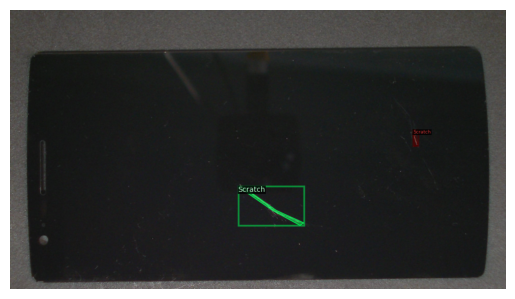

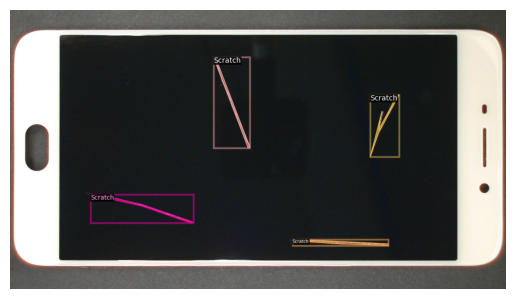

In [5]:
# Display two random training samples with annotations overlaid
from matplotlib import pyplot as plt

for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],
                            metadata=train_metadata,
                            scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    axis('off')
    plt.show()


---

## 4. Training on Custom Dataset

Set up training configuration (batch size, learning rate, iterations, etc.) and run model training.


In [7]:
from detectron2.engine import DefaultTrainer

# Prepare a fresh config for training
cfg = get_cfg()
cfg.OUTPUT_DIR = "models/Detectron2_Models"
cfg.merge_from_file(
    "detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST  = ()  # no test set during training
cfg.DATALOADER.NUM_WORKERS = 2

# Initialize from pretrained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.SOLVER.IMS_PER_BATCH = 1       # Effective batch size
cfg.SOLVER.BASE_LR = 0.00025       # Learning rate
cfg.SOLVER.MAX_ITER = 1000         # Total training iterations
cfg.SOLVER.STEPS = []              # No LR decay
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # RoI proposals per image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # Number of target classes

# Create output dir if not existing
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)


[05/18 18:03:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

In [8]:
# Train Model
 
trainer.train()

[05/18 18:03:17 d2.engine.train_loop]: Starting training from iteration 0
[05/18 18:03:36 d2.utils.events]:  eta: 0:13:33  iter: 19  total_loss: 3.116  loss_cls: 1.807  loss_box_reg: 0.3668  loss_mask: 0.69  loss_rpn_cls: 0.09041  loss_rpn_loc: 0.0326    time: 0.7728  last_time: 0.5931  data_time: 0.1890  last_data_time: 0.0010   lr: 4.9953e-06  max_mem: 4997M
[05/18 18:03:52 d2.utils.events]:  eta: 0:13:16  iter: 39  total_loss: 2.953  loss_cls: 1.6  loss_box_reg: 0.4717  loss_mask: 0.6639  loss_rpn_cls: 0.07051  loss_rpn_loc: 0.03552    time: 0.7747  last_time: 1.0899  data_time: 0.0010  last_data_time: 0.0008   lr: 9.9902e-06  max_mem: 4997M
[05/18 18:03:53 d2.engine.hooks]: Overall training speed: 39 iterations in 0:00:30 (0.7933 s / it)
[05/18 18:03:53 d2.engine.hooks]: Total training time: 0:00:30 (0:00:00 on hooks)
[05/18 18:03:53 d2.utils.events]:  eta: 0:13:47  iter: 41  total_loss: 2.953  loss_cls: 1.583  loss_box_reg: 0.4431  loss_mask: 0.6629  loss_rpn_cls: 0.07051  loss_rp

KeyboardInterrupt: 

In [9]:
import yaml

config_yaml_path = "models/Detectron2_Models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)


---

## 6. Inference & Evaluation on Validation Set

Load the best‐trained model, update threshold, and run on validation images. Then compute COCO metrics.


In [10]:
# Re-setup logger & imports (in case of new session)
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Point to the trained weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)


[05/18 18:04:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from models/Detectron2_Models\model_final.pth ...


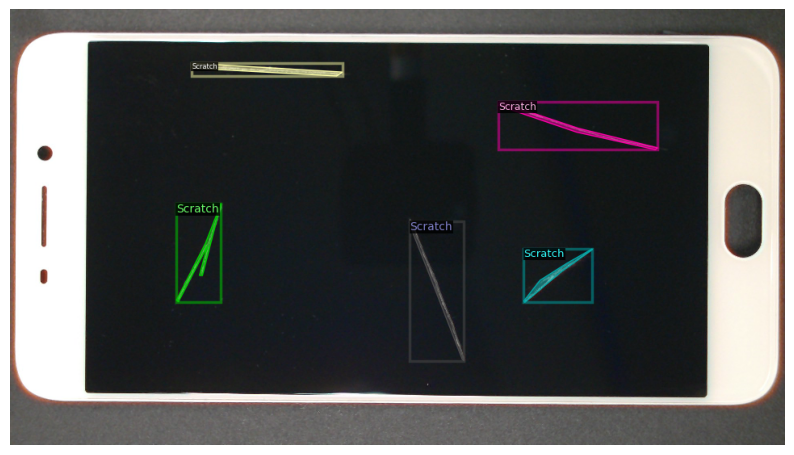

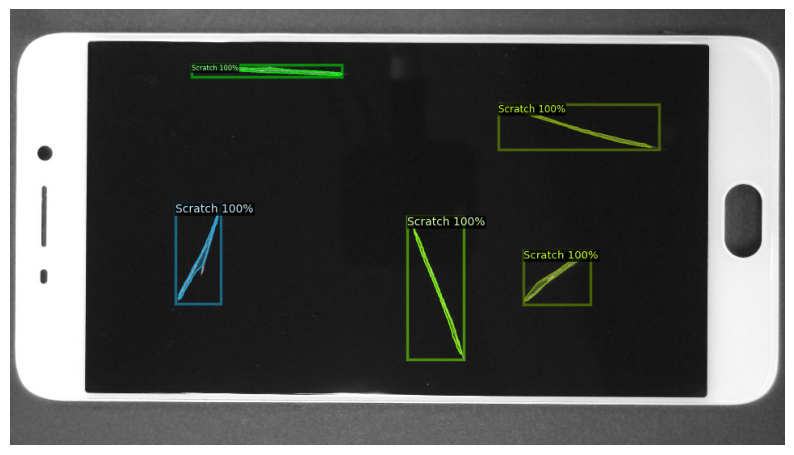

In [11]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt

# Visual check on a random validation image
for d in random.sample(val_dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=val_metadata,
        scale=0.5,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Original annotations
    visualizer = Visualizer(im[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)

    # Display side by side
    plt.figure(figsize=(10,10))
    imshow(vis.get_image()[:, :, ::-1]); axis('off'); show()
    plt.figure(figsize=(10,10))
    imshow(out.get_image()[:, :, ::-1]); axis('off'); show()


In [12]:
# COCO-style quantitative evaluation
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


[05/18 18:04:05 d2.data.datasets.coco]: Loaded 5 images in COCO format from Datasets/mobileScratches/testing/testing_ann.json
[05/18 18:04:05 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  Scratch   | 18           |
|            |              |
[05/18 18:04:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/18 18:04:05 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/18 18:04:05 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[05/18 18:04:05 d2.data.common]: Serialized dataset takes 0.01 MiB
[05/18 18:04:05 d2.evaluation.evaluator]: Start inference on 5 batches
[05/18 18:04:12 d2.evaluation.evaluator]: Total inference time: 0:00:00.538319 (0.538319 s / iter per device, on 1 devices)
[05/18 18:

---

## 7. Utility: Quick Segmentation Function

Create a helper function for one-line segmentation on any image.


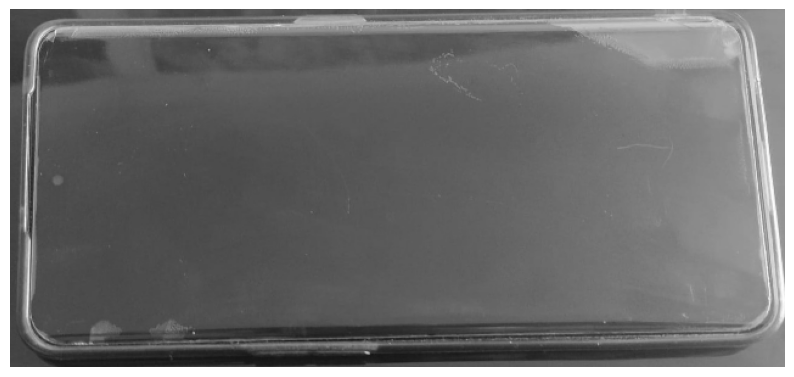

In [13]:
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt

def segment_image(image_path):
    """
    Load an image, run the trained predictor, and display the segmentation result.
    
    Args:
        image_path (str): Path to the input image file.
    """
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=val_metadata,
        scale=0.5,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10,10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

# Example usage
segment_image("sample_image.jpg")
